In [135]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import matplotlib.pyplot as plt
%matplotlib inline

# In this notebook, we wrap up our analysis of Box Office Performance + Text

We do the following:
* Build a dataset without outliers (bottom 20%, top 20%)
* Split analysis by genre
* Compare model with concrete words (week 1) vs. dimensions/word ranks (week 2)
* Build a model that uses concrete words, dimensions and word ranks for classification

# Load NF dimensions and embedding model

In [47]:
# assume that we have a dimensions csv file in data
dimensions = pd.read_csv('data/dimensions.csv', usecols = ['en_label', 'en'])

In [48]:
# remove brand-specific labels
dimensions = dimensions.iloc[:200]

In [49]:
# remove rows with no words
dimensions = dimensions[~dimensions['en'].isnull()]

In [50]:
# turn to lowercase
dimensions['en_label'] = dimensions['en_label'].str.lower()
dimensions['en'] = dimensions['en'].str.lower()

In [51]:
# tokenize words
dimensions['tokenized'] = dimensions['en'].str.replace('-', '_').str.replace(',', ' ').map(word_tokenize)

In [52]:
# load embedding model
emb = gensim.models.KeyedVectors.load_word2vec_format('data/en_en_numberbatch_v1706.bin', binary=True)

In [53]:
def get_average_vector(words):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [54]:
dimensions['dimension'] = dimensions['tokenized'].map(get_average_vector)
dimensions = dimensions.drop(columns=['en'])

In [55]:
dimensions = dimensions.reset_index().drop(columns='index')

In [56]:
# get word ranks from embedding model
word_rank = pd.Series(list(emb.vocab.keys())).reset_index()

In [57]:
# divide word ranks into deciles
word_rank['percentile'] = pd.qcut(word_rank['index'], 10, labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+'])

In [58]:
rank_dict = dict(zip(word_rank[0].values, word_rank['percentile'].values))

In [59]:
rank_labels = word_rank['percentile'].unique()

# Create dataset w/o outliers

In [38]:
# load data from the week 1 notebook
pc = pd.read_csv('data/wiki_matched.csv')

In [39]:
pc['tokenized_words'] = pc['movie_title'].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').str.replace(r'\'', '').map(word_tokenize)
pc['wiki_tokenized_words'] = pc['wiki_synopsis'].str.replace(r'[^a-zA-Z0-9 ]', '').str.replace(r'\'', '').map(word_tokenize)

In [195]:
# only retain genre, total gross per cinema, and text features
reduced = pc[['movie_title', 'genre1', 'genre2', 'adjusted_total_gross_per_cinema', 'wiki_synopsis', 'tokenized_words', 'wiki_tokenized_words']]

In [202]:
# get average word vectors assuming all words in the title/synopsis have equal weight
reduced['wv_title'] = reduced['tokenized_words'].map(get_average_vector)
reduced['wv_synopsis'] = reduced['wiki_tokenized_words'].map(get_average_vector)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [203]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [204]:
def get_similarity_with_dimensions(row, inp, dimensions, tfidf = False):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        inp : either 'title' or 'synopsis'
        dimensions : dataframe containing Neuroflash dimensions
        tfidf : true if we are using TFIDF-weighted sentence vectors
    """
    for k in range(dimensions['dimension'].shape[0]):
        if tfidf:
            wv = 'wv_' + inp + '_tfidf'
            name = 'cos_' + inp + '_dim_' + str(k) + '_tfidf'
        else: 
            wv = 'wv_' + inp
            name = 'cos_' + inp + '_dim_' + str(k)  
        # define a new column for the cosine similarity of dimension k and inp
        row[name] = cosine_similarity(row[wv], dimensions['dimension'].iloc[k])
    return row

In [328]:
def get_tfidf_wv(row, emb, d, col = 'wiki_tokenized_words'):
    """
        Get TFIDF-weighted vector for either title or synopsis.
        row : row of movie dataframe
        emb : embedding model used
        d : Gensim dictionary for the corpus
        col : either 'wiki_tokenized_words' (synopsis) or 'tokenized_words' (title)
    """
    if col == 'wiki_tokenized_words':
        tfidf_map = row['wiki_tfidf_map']
        name = 'wv_synopsis'
    else:
        tfidf_map = row['tfidf_map']
        name = 'wv_title'
    words = row[col]
    total = np.zeros(300)
    for word in words:
        if (word in d.token2id.keys() and d.token2id[word] in tfidf_map.keys() and word in emb.vocab.keys()):
            # use the TFIDF of word as the weight to the word vector of word
            total += np.array(tfidf_map[d.token2id[word]] * emb[word])
    count = len(total)
    if count == 0:
        row[name + '_tfidf'] = np.nan
    else:
        row[name + '_tfidf'] = total / count
    return row

In [329]:
def get_word_rank_count(row, inp, rank_dict, rank_labels):
    """
        Get the frequency of the word rank deciles <10 to 90+
        row : row of movie dataframe
        inp : either 'title' or 'synopsis'
        rank_dict : dictionary from words to ranks
        rank_labels : labels for the word rank deciles
    """
    if inp == 'title':
        val = 'tokenized_words'
    elif inp == 'synopsis':
        val = 'wiki_tokenized_words'
    else:
        return
    word_count = len(row[val])
    running = 0
    for k in range(10):
        # count the number of words belonging to decile k
        total = np.sum([1 for y in [rank_dict[x] for x in row[val] if x in rank_dict.keys()] if y == rank_labels[k]]) 
        # divide by the total number of words to get frequency
        freq = total / word_count
        row['freq_' + inp + '_'+ rank_labels[k]] = freq
        running += freq
    row['freq_' + inp + '_notinemb'] = 1 - running
    return row

In [206]:
# retain only rows with filled-up title and synopis
reduced = reduced[~reduced['wv_title'].isnull()]
reduced = reduced[~reduced['wv_synopsis'].isnull()]

In [207]:
reduced = reduced.apply(lambda x: get_word_rank_count(x, 'title', rank_dict, rank_labels), axis=1)
reduced = reduced.apply(lambda x: get_word_rank_count(x, 'synopsis', rank_dict, rank_labels), axis=1)

In [208]:
reduced['gross_percentile'] = pd.qcut(reduced['adjusted_total_gross_per_cinema'], 5, labels = ['<20', '20-40', '40-60', '60-80', '>80'])

We remove movies that have gross in the top 20% and bottom 20%.

In [209]:
no_blockbuster = reduced[~reduced['gross_percentile'].isin(['<20', '>80'])]

In [210]:
print("After removing outliers, we go from " + str(reduced.shape[0]) + " rows to " + str(no_blockbuster.shape[0]) + " rows.")

After removing outliers, we go from 3241 rows to 1953 rows.


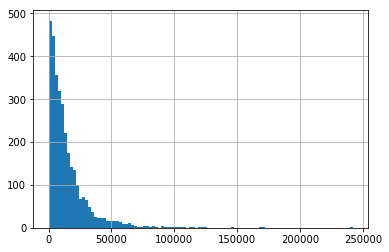

In [211]:
reduced['adjusted_total_gross_per_cinema'].hist(bins = 100);

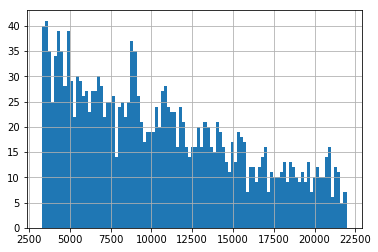

In [212]:
no_blockbuster['adjusted_total_gross_per_cinema'].hist(bins = 100)

Let us look at frequency counts per genre.

In [215]:
print(no_blockbuster['adjusted_total_gross_per_cinema'].min())
print(no_blockbuster['adjusted_total_gross_per_cinema'].max())
print((no_blockbuster['adjusted_total_gross_per_cinema'].max() - no_blockbuster['adjusted_total_gross_per_cinema'].min())/3)

3302.3543990086737
21960.0
6219.215200330443


In [167]:
no_blockbuster['genre1'].value_counts().sort_values(ascending=False).head()

Drama          450
Comedy         310
Foreign        289
Action         150
Documentary    149
Name: genre1, dtype: int64

In [219]:
no_blockbuster['genre1'].value_counts().add(no_blockbuster['genre2'].value_counts(), fill_value=0).sort_values(ascending=False).head()

Drama       662.0
Comedy      424.0
Foreign     289.0
Thriller    198.0
Action      195.0
dtype: float64

In our wrap-up, let us focus only on the top 3 genres: **Drama**, **Comedy** and **Foreign**.

# Class Definitions
We consider a 3-way multiclass problem for low, medium, high-grossing movies.

We will consider two types of binning: (1) binning with unequal binwidths based on 3-quantiles, which yields a balanced problem, and (2) equal binning with equal binwidths, which yields an imbalanced problem.

We will assess the performance of our models in the two problems defined above.

In [231]:
no_blockbuster['class_balanced'] = pd.qcut(no_blockbuster['adjusted_total_gross_per_cinema'],3, ['low', 'medium', 'high'])

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [304]:
min_val = no_blockbuster['adjusted_total_gross_per_cinema'].min()
max_val = no_blockbuster['adjusted_total_gross_per_cinema'].max()
width = (max_val - min_val)/3

def map_class_imbalanced(x):
    if x < min_val + width:
        return 0
    elif x < min_val + 2* width:
        return 1
    else:
        return 2

In [305]:
no_blockbuster['class_imbalanced'] = no_blockbuster['adjusted_total_gross_per_cinema'].map(lambda x: map_class_imbalanced(x))

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [306]:
no_blockbuster['class_imbalanced'].value_counts() / no_blockbuster['class_balanced'].value_counts().sum()

0    0.489891
1    0.325557
2    0.196993
Name: class_imbalanced, dtype: float64

Almost a 3:2:1 imbalance ratio for equal binwidth

In [307]:
_, bins = pd.qcut(no_blockbuster['adjusted_total_gross_per_cinema'], 3, retbins=True)
bins

array([ 3302.35439901,  7284.96836185, 12569.40764852, 21960.        ])

In [316]:
no_blockbuster['class_balanced'] = pd.qcut(no_blockbuster['adjusted_total_gross_per_cinema'], 3, [0, 1, 2])

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [317]:
no_blockbuster['class_balanced'].value_counts()

2    643
1    643
0    643
Name: class_balanced, dtype: int64

Balanced classes but unequal binwidth

In [244]:
no_blockbuster[(no_blockbuster['genre1'] == 'Foreign') | (no_blockbuster['genre2'] == 'Foreign')]

,movie_title,genre1,genre2,adjusted_total_gross_per_cinema,wiki_synopsis,tokenized_words,wiki_tokenized_words,wv_title,wv_synopsis,freq_title_<10,...,freq_synopsis_40-50,freq_synopsis_50-60,freq_synopsis_60-70,freq_synopsis_70-80,freq_synopsis_80-90,freq_synopsis_90+,freq_synopsis_notinemb,gross_percentile,class_balanced,class_imbalanced
170,Golmaal 3,Foreign,NaN,14217.441860,the story follows pritam mithun chakraborty ...,"[golmaal, 3]","[the, story, follows, pritam, mithun, chakrabo...","[0.02015, 0.032449998, 0.02645, -0.011999999, ...","[0.10275308, 0.09808642, 0.02383278, -0.007670...",0.500000,...,0.012788,0.000000,0.000000,0.000000,0.002558,0.000000,0.040921,60-80,high,medium
173,Tees Maar Khan,Foreign,NaN,10792.592593,tees maar khan mainly revolves around conman t...,"[tees, maar, khan]","[tees, maar, khan, mainly, revolves, around, c...","[-0.038966667, 0.0327, 0.049333334, 0.03493333...","[0.10001644, 0.10654033, 0.014809947, -0.01762...",0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049645,40-60,medium,medium
180,I Hate Luv Storys,Foreign,NaN,11192.941176,simran sonam kapoor loves bollywood romances...,"[i, hate, luv, storys]","[simran, sonam, kapoor, loves, bollywood, roma...","[0.10646667, 0.100766666, -0.0132, 0.058066666...","[0.12133621, 0.11441462, 0.009227573, -0.01161...",0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002695,40-60,medium,medium
183,Peepli Live,Foreign,NaN,12148.571429,natha das manikpuri omkar das manikpuri bet...,"[peepli, live]","[natha, das, manikpuri, omkar, das, manikpuri,...","[0.1022, 0.1188, 0.0182, 0.0114, -0.0187, -0.0...","[0.10536414, 0.10140981, 0.011342944, -0.02551...",0.500000,...,0.000000,0.000000,0.001481,0.040000,0.000000,0.000000,0.054815,40-60,medium,medium
190,We Are Family,Foreign,NaN,9178.205128,maya kajol is a perfect mother whose life re...,"[we, are, family]","[maya, kajol, is, a, perfect, mother, whose, l...","[0.0791, 0.07840001, 0.016166667, 0.005200001,...","[0.1120547, 0.10354114, 0.020151244, -0.018344...",1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012259,40-60,medium,low
209,Heartbreaker,Foreign,NaN,12923.255814,the bulk of the story takes place in monaco c...,[heartbreaker],"[the, bulk, of, the, story, takes, place, in, ...","[0.0665, 0.0674, 0.0066, 0.0675, 0.1127, -0.01...","[0.11193872, 0.11216913, 0.015663216, -0.02146...",0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004815,60-80,high,medium
213,Break Ke Baad,Foreign,NaN,5432.941176,abhay gulati imran khan and aaliya khan dee...,"[break, ke, baad]","[abhay, gulati, imran, khan, and, aaliya, khan...","[0.0965, 0.0602, 0.0497, -0.0032000002, -0.022...","[0.119555265, 0.11351552, 0.013026134, -0.0133...",0.333333,...,0.002257,0.000000,0.000000,0.000000,0.000000,0.000000,0.006772,20-40,low,low
215,Wild Grass,Foreign,NaN,19673.913043,marguerite muir is a dentist single and middl...,"[wild, grass]","[marguerite, muir, is, a, dentist, single, and...","[0.0308, -0.01265, 0.2089, 0.13745001, 0.07629...","[0.08880065, 0.098406754, 0.028735818, -0.0300...",1.000000,...,0.000000,0.000000,0.000000,0.006711,0.000000,0.000000,0.006711,60-80,high,high
218,Lebanon,Foreign,NaN,17869.565217,the film depicts warfare as witnessed exclusiv...,[lebanon],"[the, film, depicts, warfare, as, witnessed, e...","[-0.1296, 0.0751, 0.0156, -0.0012, -0.005, 0.0...","[0.0993929, 0.09675734, 0.02718088, -0.0469617...",1.000000,...,0.000000,0.004425,0.000000,0.004425,0.000000,0.000000,0.004425,60-80,high,high
230,White Material,Foreign,NaN,15695.238095,maria vial is a white french farmer who runs ...,"[white, material]","[maria, vial, is, a, white, french, farmer, wh...","[0.07785, -0.04315, 0.19455001, -0.04785, -0.0...","[0.10041517, 0.10772207, 0.025129834, -0.01524...",1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007547,60-80,high,medium


# Comparing Models

* Let Model A refer to the model built on TFIDF weights of the concrete words in the title and synopsis
* Let Model B refer to the model built on dimension similarities and word ranks
* Let Model C refer to the model built on Model A and Model B's features

In [337]:
def generate_and_split_dataset_for_genre_classification(pc, emb, genre = '', var = 'class_balanced', concrete_words = True, similarity_rank = False, tfidf = False, whole = False):
    """
        Split train and tests sets for the specific genre
        
        Input:
            pc : dataframe of features
            genre : genre to filter
            var : box office performance metric
            w2v : whether to include word2vec features
            tfidf : whether to use tfidf weighting to get embedding sentence vector
            whole: whether to train on whole dataset or not
        Output:
            X_train : input training set
            X_test : input test set
            y_train : output training set
            y_test : output test set
            column_names : list of feature names
    """
    
    # check whether genre is provided
    # if yes, filter pc by genre
    if genre == '':
        pc = pc
    else:
        pc = pc[(pc['genre1'] == genre) | (pc['genre2'] == genre)]
    
    # only retain rows with non-null performance metric
    pc = pc[~pc[var].isnull()]
    
    column_names = ['movie_title', 'wiki_synopsis', 'tokenized_words', 'wiki_tokenized_words', 'wv_title', 'wv_synopsis', var] + [x for x in pc.columns if 'freq' in x]
    X = pc[column_names]
    
    if whole:
        X_train = X
        y_train = pc[var]
    
    else:
        # split 50-25-25 train-validation-test split
        X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                pc[var], test_size=0.25, stratify = pc[var], random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                y_trainval, test_size=1/3, stratify = y_trainval, random_state=0)
        X_train = pd.DataFrame(X_train, columns=column_names)
        X_val = pd.DataFrame(X_val, columns=column_names)
        X_test = pd.DataFrame(X_test, columns=column_names)

    if similarity_rank:
        dict_synopsis = Dictionary(X_train['wiki_tokenized_words'].values)
        dict_title = Dictionary(X_train['tokenized_words'].values)

        corpus_synopsis_train = [dict_synopsis.doc2bow(line) for line in X_train['wiki_tokenized_words'].values]
        corpus_title_train = [dict_title.doc2bow(line) for line in X_train['tokenized_words'].values]

        model_synopsis = TfidfModel(corpus_synopsis_train, id2word=dict_synopsis) 
        model_title = TfidfModel(corpus_title_train, id2word=dict_title) 

        if tfidf:
            X_train['wiki_tfidf_map'] = corpus_synopsis_train
            X_train['tfidf_map'] = corpus_title_train
            X_train['wiki_tfidf_map'] = X_train['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
            X_train['tfidf_map'] = X_train['tfidf_map'].map(lambda x: dict(model_title[x]))
            X_train = X_train.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis, 'wiki_tokenized_words'), axis=1)
            X_train = X_train.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)   

        X_train = X_train.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
        X_train = X_train.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

        if tfidf:
            column_names = [x for x in X_train.columns if (((x.startswith('cos') and x.endswith('tfidf'))) or 'freq' in x)]
        else:
            column_names = [x for x in X_train.columns if ((x.startswith('cos')) or 'freq' in x)]

    if concrete_words:
        # obtain tfidf representation for words in the training set
        # only consider up to 2-grams, and filter out tokens appearing in < 4 titles
        tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 4)
        tfidf_features = tfidf.fit_transform(X_train['movie_title'].values)
        tfidf_df = pd.DataFrame(tfidf_features.toarray(), index = X_train.index,
                 columns=['title_' + x for x in tfidf.vocabulary_.keys()])

        # tfidf for the synopsis
        wiki_tfidf = TfidfVectorizer(stop_words='english', min_df = 20)
        wiki_tfidf_features = wiki_tfidf.fit_transform(X_train['wiki_synopsis'].values)
        wiki_tfidf_df = pd.DataFrame(wiki_tfidf_features.toarray(), index = X_train.index,
                 columns=['synopsis_' + x for x in wiki_tfidf.vocabulary_.keys()])
    
    to_concat = []
    if similarity_rank:
        to_concat.extend([X_train[column_names]])
    if concrete_words:
        to_concat.extend([tfidf_df, wiki_tfidf_df])
    X_train = pd.concat(to_concat, axis=1)
    
    pad = X_train.mean()
    X_train = X_train.fillna(pad)
    
    column_names = X_train.columns
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)

    if whole:
        return X_train, None, None, y_train, None, None, column_names

    else:
        if similarity_rank:
            corpus_synopsis_val = [dict_synopsis.doc2bow(line) for line in X_val['wiki_tokenized_words'].values]
            corpus_title_val = [dict_title.doc2bow(line) for line in X_val['tokenized_words'].values]

            corpus_synopsis_test = [dict_synopsis.doc2bow(line) for line in X_test['wiki_tokenized_words'].values]
            corpus_title_test = [dict_title.doc2bow(line) for line in X_test['tokenized_words'].values]

            if tfidf:
                X_val['wiki_tfidf_map'] = corpus_synopsis_val
                X_val['tfidf_map'] = corpus_title_val
                X_val['wiki_tfidf_map'] = X_val['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
                X_val['tfidf_map'] = X_val['tfidf_map'].map(lambda x: dict(model_title[x]))
                X_val = X_val.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis), axis=1)
                X_val = X_val.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)

            X_val = X_val.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
            X_val = X_val.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

            if tfidf:
                X_test['wiki_tfidf_map'] = corpus_synopsis_test
                X_test['tfidf_map'] = corpus_title_test
                X_test['wiki_tfidf_map'] = X_test['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
                X_test['tfidf_map'] = X_test['tfidf_map'].map(lambda x: dict(model_title[x]))
                X_test = X_test.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis), axis=1)
                X_test = X_test.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)

            X_test = X_test.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
            X_test = X_test.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

        if concrete_words:
            # get tfidf representation of validation set
            tfidf_features_val = tfidf.transform(X_val['movie_title'].values)
            tfidf_df_val = pd.DataFrame(tfidf_features_val.toarray(), \
                    index = X_val.index, columns=tfidf_df.columns)
            wiki_tfidf_features_val = wiki_tfidf.transform(X_val['wiki_synopsis'].values)
            wiki_tfidf_df_val = pd.DataFrame(wiki_tfidf_features_val.toarray(), \
                    index = X_val.index, columns=wiki_tfidf_df.columns)
            
            # get tfidf representation of test set
            tfidf_features_test = tfidf.transform(X_test['movie_title'].values)
            tfidf_df_test = pd.DataFrame(tfidf_features_test.toarray(), \
                    index = X_test.index, columns=tfidf_df.columns)
            wiki_tfidf_features_test = wiki_tfidf.transform(X_test['wiki_synopsis'].values)
            wiki_tfidf_df_test = pd.DataFrame(wiki_tfidf_features_test.toarray(), \
                    index = X_test.index, columns=wiki_tfidf_df.columns)
            
        X_val = X_val.fillna(pad)
        X_test = X_test.fillna(pad)

        to_concat_val = []
        to_concat_test = []
        if similarity_rank:
            to_concat_val.extend([X_val[column_names]])
            to_concat_test.extend([X_test[column_names]])
        if concrete_words:
            to_concat_val.extend([tfidf_df_val, wiki_tfidf_df_val])
            to_concat_test.extend([tfidf_df_test, wiki_tfidf_df_test])

        X_val = pd.concat(to_concat_val, axis=1)
        X_test = pd.concat(to_concat_test, axis=1)
        
        X_val = ss.transform(X_val)
        X_test = ss.transform(X_test)

        return X_train, X_val, X_test, y_train, y_val, y_test, column_names

In [333]:
def train_model(modeltype, X_train, y_train, C=1):
    """
        Train chosen model.
        
        Input:
            modeltype : 'lr'. I wrote this to be extendable easily.
            X_train : input training set
            y_train : output training set
        Output:
            model : trained linear regression model
    """

    if modeltype == 'lr':
        model = LogisticRegression(class_weight='balanced', C=C)
    model.fit(X_train, y_train)
    return model

In [334]:
def evaluate_model(model, X, y):
    """
        Evaluate trained model.
        
        Input:
            X : input to model
            y : output to predict
    """
    
    print('accuracy : {}'.format(model.score(X, y)))
    print(classification_report(y, model.predict(X)))
    print(confusion_matrix(y, model.predict(X)))

In [335]:
def plot_most_relevant_features(model, column_names, n=5):
    """
        Plot the features which have the highest effect on
        box office performance based on the mode.
        
        Input:
            model : trained LR model
            column_names : list of features
            n : number of features to include (in one direction)
    """
    
    coef_low = model.coef_[0]
    coef_medium = model.coef_[1]
    coef_high = model.coef_[2]
    
    coef_low_sorted = list(coef_low[np.argsort(-coef_low)])
    columns_low_sorted = list(np.array(column_names)[np.argsort(-coef_low)])
    coef_medium_sorted = list(coef_medium[np.argsort(-coef_medium)])
    columns_medium_sorted = list(np.array(column_names)[np.argsort(-coef_medium)])
    coef_high_sorted = list(coef_high[np.argsort(-coef_high)])
    columns_high_sorted = list(np.array(column_names)[np.argsort(-coef_high)])    

    plt.figure(figsize=(15,6))
    
    plt.subplot(131)
    plt.bar(range(2*n), coef_low_sorted[:n] + coef_low_sorted[-n:])
    plt.xticks(range(2*n), columns_low_sorted[:n] + columns_low_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.ylabel('Coefficient', size=20)
    plt.title('Low gross', size=21);
    
    plt.subplot(132)
    plt.bar(range(2*n), coef_medium_sorted[:n] + coef_medium_sorted[-n:])
    plt.xticks(range(2*n), columns_medium_sorted[:n] + columns_medium_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.title('Medium gross', size=21);
    
    plt.subplot(133)
    plt.bar(range(2*n), coef_high_sorted[:n] + coef_high_sorted[-n:])
    plt.xticks(range(2*n), columns_high_sorted[:n] + columns_high_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.title('High gross', size=21);

### Generate features and dataset splits for Models A, B, C for Drama, Comedy and Foreign

In [345]:
for genre in ['Drama', 'Comedy', 'Foreign']:
    for similarity_rank in [False, True]:
        for concrete_word in [False, True]:
            for balanced in ['class_balanced', 'class_imbalanced']:                    
                print(genre, concrete_word, similarity_rank, balanced)
                if (not concrete_word and not similarity_rank) or (concrete_word and similarity_rank):
                    continue
                X_train, X_val, X_test, y_train, y_val, y_test, column_names = \
                    split_dataset_for_genre_classification(no_blockbuster, emb, genre = genre, var = balanced, \
                    concrete_words = concrete_word, similarity_rank = similarity_rank, tfidf = True, whole = False)
                if concrete_word:
                    if similarity_rank:
                        label = 'C'
                    else:
                        label = 'A'
                else:
                    label = 'B'
                pd.DataFrame(X_train, columns=column_names).to_csv('data/{}_model_{}_{}_X_train.csv'.format(genre, label, balanced), index=False)
                pd.DataFrame(X_val, columns=column_names).to_csv('data/{}_model_{}_{}_X_val.csv'.format(genre, label, balanced), index=False)
                pd.DataFrame(X_test, columns=column_names).to_csv('data/{}_model_{}_{}_X_test.csv'.format(genre, label, balanced), index=False)
                y_train.to_csv('data/{}_model_{}_{}_y_train.csv'.format(genre, label, balanced), index=False)
                y_val.to_csv('data/{}_model_{}_{}_y_val.csv'.format(genre, label, balanced), index=False)
                y_test.to_csv('data/{}_model_{}_{}_y_test.csv'.format(genre, label, balanced), index=False)

Drama False False class_balanced
Drama False False class_imbalanced
Drama True False class_balanced
Drama True False class_imbalanced
Drama False True class_balanced


/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Drama False True class_imbalanced


KeyboardInterrupt: 

In [318]:
X_train, X_val, X_test, y_train, y_val, y_test, column_names = \
                split_dataset_for_genre_classification(no_blockbuster, emb, genre = 'Foreign', var = 'class_balanced', \
                concrete_words = True, similarity_rank = False, tfidf = True, whole = False)

In [41]:
model_lr_1 = train_model('lr', X_train.values, y_train, 1)
model_lr_10 = train_model('lr', X_train, y_train, 10)
model_lr_100 = train_model('lr', X_train, y_train, 100)
model_lr_1000 = train_model('lr', X_train, y_train, 1000)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [38]:
evaluate_model(model_lr_1, X_test, y_test)

accuracy : 0.4636363636363636
             precision    recall  f1-score   support

          0       0.74      0.53      0.62       539
          1       0.22      0.33      0.26       171
          2       0.11      0.23      0.15        60

avg / total       0.58      0.46      0.50       770

[[287 172  80]
 [ 82  56  33]
 [ 19  27  14]]


In [39]:
evaluate_model(model_lr_10, X_val, y_val)

accuracy : 0.5107212475633528
             precision    recall  f1-score   support

          0       0.73      0.62      0.67       718
          1       0.22      0.31      0.26       228
          2       0.09      0.11      0.10        80

avg / total       0.56      0.51      0.53      1026

[[444 210  64]
 [133  71  24]
 [ 35  36   9]]


In [35]:
evaluate_model(model_lr_100, X_val, y_val)

accuracy : 0.39473684210526316
             precision    recall  f1-score   support

          0       0.76      0.42      0.54       718
          1       0.23      0.36      0.28       228
          2       0.09      0.31      0.14        80

avg / total       0.59      0.39      0.45      1026

[[299 241 178]
 [ 71  81  76]
 [ 23  32  25]]


In [36]:
evaluate_model(model_lr_1000, X_val, y_val)

accuracy : 0.4512670565302144
             precision    recall  f1-score   support

          0       0.77      0.48      0.59       718
          1       0.26      0.38      0.30       228
          2       0.12      0.36      0.18        80

avg / total       0.61      0.45      0.50      1026

[[348 220 150]
 [ 83  86  59]
 [ 21  30  29]]


### Using TFIDF weighting + word2vec to get sentence vectors

In [ ]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train_tfidf, y_val_tfidf, y_test_tfidf = split_dataset_for_genre_classification(no_blockbuster, emb, genre = '', var = 'gross_bracket', tfidf = True, whole = False)

In [44]:
# X_train_tfidf.to_csv('data/tfidf_X_train.csv')
# X_val_tfidf.to_csv('data/tfidf_X_val.csv')
# X_test_tfidf.to_csv('data/tfidf_X_test.csv')
# y_train_tfidf.to_csv('data/tfidf_y_train.csv')
# y_val_tfidf.to_csv('data/tfidf_y_val.csv')
# y_test_tfidf.to_csv('data/tfidf_y_test.csv')
X_train_tfidf = pd.read_csv('data/tfidf_X_train.csv').drop(columns = 'Unnamed: 0')
X_val_tfidf = pd.read_csv('data/tfidf_X_val.csv').drop(columns = 'Unnamed: 0')
X_test_tfidf = pd.read_csv('data/tfidf_X_test.csv').drop(columns = 'Unnamed: 0')
y_train_tfidf = pd.read_csv('data/tfidf_y_train.csv', header=None).drop(columns = 0)
y_val_tfidf = pd.read_csv('data/tfidf_y_val.csv', header=None).drop(columns = 0)
y_test_tfidf = pd.read_csv('data/tfidf_y_test.csv', header=None).drop(columns = 0)

In [45]:
model_lr_1_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 1)
model_lr_10_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 10)
model_lr_100_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 100)
model_lr_1000_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 1000)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
evaluate_model(model_lr_1_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.6608187134502924
             precision    recall  f1-score   support

          0       0.72      0.90      0.80       718
          1       0.32      0.11      0.16       228
          2       0.14      0.10      0.12        80

avg / total       0.59      0.66      0.61      1026

[[645  37  36]
 [190  25  13]
 [ 57  15   8]]


In [47]:
evaluate_model(model_lr_10_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.6169590643274854
             precision    recall  f1-score   support

          0       0.73      0.81      0.77       718
          1       0.28      0.18      0.22       228
          2       0.13      0.12      0.13        80

avg / total       0.58      0.62      0.59      1026

[[582  84  52]
 [170  41  17]
 [ 49  21  10]]


In [48]:
evaluate_model(model_lr_100_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.5964912280701754
             precision    recall  f1-score   support

          0       0.72      0.78      0.75       718
          1       0.26      0.19      0.22       228
          2       0.14      0.15      0.14        80

avg / total       0.57      0.60      0.58      1026

[[557 106  55]
 [166  43  19]
 [ 49  19  12]]


In [49]:
evaluate_model(model_lr_1000_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.5662768031189084
             precision    recall  f1-score   support

          0       0.71      0.74      0.72       718
          1       0.24      0.19      0.21       228
          2       0.09      0.11      0.10        80

avg / total       0.56      0.57      0.56      1026

[[528 122  68]
 [161  44  23]
 [ 51  20   9]]


Judging by accuracy, I should go with averaging and C = 1

Judging by F1, I should go with TFIDF and C = 1

In [114]:
evaluate_model(model_lr_1, X_test, y_test)

accuracy : 0.6714285714285714
             precision    recall  f1-score   support

          0       0.72      0.93      0.81       539
          1       0.32      0.08      0.12       171
          2       0.11      0.07      0.08        60

avg / total       0.58      0.67      0.60       770

[[500  19  20]
 [147  13  11]
 [ 47   9   4]]


In [115]:
evaluate_model(model_lr_1_tfidf, X_test_tfidf, y_test_tfidf)

accuracy : 0.6584415584415585
             precision    recall  f1-score   support

          0       0.73      0.89      0.80       539
          1       0.32      0.11      0.16       171
          2       0.14      0.12      0.13        60

avg / total       0.59      0.66      0.61       770

[[482  27  30]
 [141  18  12]
 [ 41  12   7]]


Assuming we go with TFIDF + C=1

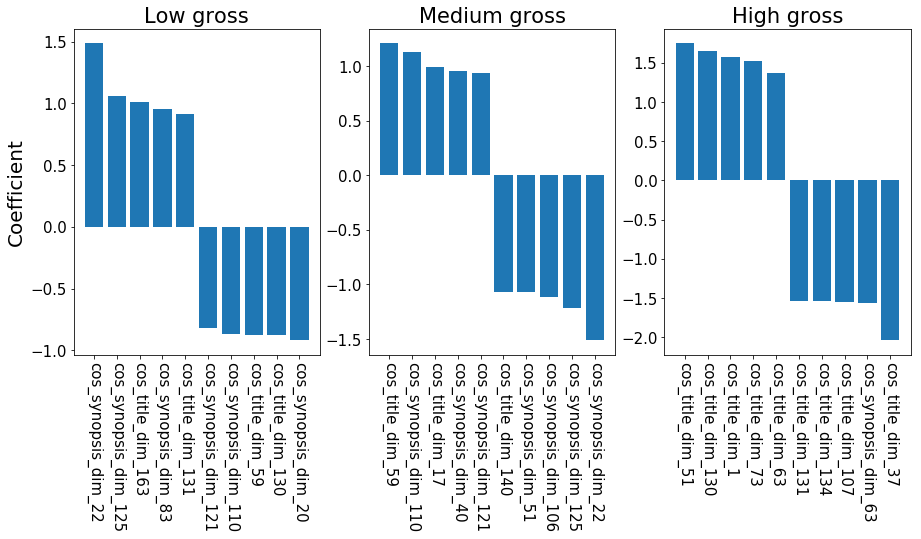

In [116]:
plot_most_relevant_features(model_lr_1_tfidf, list(X_train.columns))

Positively associated with low grossing movies:

In [117]:
dimensions[['en_label', 'tokenized']].iloc[[22,125,163, 83, 131]]

,en_label,tokenized
22,career,"[executive, management, professional, corporat..."
125,sport,"[sport, volleyball, basketball, fussball, hand..."
163,valuable,"[valuable, good_reputation, prestigious, recog..."
83,lifestyle,"[life, lifestyle, freedom]"
131,technical,"[technical, high_tech, industrial, mechanical,..."


Negatively associated with low grossing movies:

In [118]:
dimensions[['en_label', 'tokenized']].iloc[[20, 130, 59, 110, 121]]

,en_label,tokenized
20,breakfast items,"[cheese, yoghurt, fat, oil, baguette, croissan..."
130,teaching,"[teaching, teach, learning, learn, course]"
59,fish,"[fish, blue]"
110,philharmonics,"[philharmonic, philharmonics, classical, classic]"
121,science,"[science, technology, physics, chemistry, eins..."


Positively associated with medium grossing movies:

In [119]:
dimensions[['en_label', 'tokenized']].iloc[[59, 110, 17, 40, 121]]

,en_label,tokenized
59,fish,"[fish, blue]"
110,philharmonics,"[philharmonic, philharmonics, classical, classic]"
17,blue_collar,"[carpenter, plumber, trucker, janitor, mechanic]"
40,innovative,"[innovative, advanced, modern, progressive, av..."
121,science,"[science, technology, physics, chemistry, eins..."


Negatively associated with medium grossing movies:

In [120]:
dimensions[['en_label', 'tokenized']].iloc[[22, 125, 106, 51, 140]]

,en_label,tokenized
22,career,"[executive, management, professional, corporat..."
125,sport,"[sport, volleyball, basketball, fussball, hand..."
106,new,"[new, fresh, all_new, brand_new, model]"
51,evaluating,"[evaluating, appraise, assess, calculate, clas..."
140,thejester,"[jester, lighten_up, great_time, play, jokes, ..."


Positively associated with high grossing movies:

In [121]:
dimensions[['en_label', 'tokenized']].iloc[[51, 130, 1, 73, 63]]

,en_label,tokenized
51,evaluating,"[evaluating, appraise, assess, calculate, clas..."
130,teaching,"[teaching, teach, learning, learn, course]"
1,added_words,"[sharing, smart, freedom, safety, comfort]"
73,winner,"[winner, champ, first, award, medal, champion,..."
63,friendship,"[friendship, friends, friend, buddy, buddies, ..."


Negatively associated with high grossing movies:

In [122]:
dimensions[['en_label', 'tokenized']].iloc[[37, 63, 107, 134, 131]]

,en_label,tokenized
37,design,"[design, modern, sleek, slender, form, idea, l..."
63,friendship,"[friendship, friends, friend, buddy, buddies, ..."
107,diligent,"[conscientious, prompt, dutiful, punctual, har..."
134,thecarer,"[neighbor, neighbor, help, helper, selfishness..."
131,technical,"[technical, high_tech, industrial, mechanical,..."


## Let's try running the model for Comedy.

In [123]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset_for_genre_classification(no_blockbuster, emb, genre = 'Comedy', var = 'gross_bracket', tfidf = False, whole = False)

In [124]:
model_lr = train_model('lr', X_train, y_train, 1)

In [125]:
evaluate_model(model_lr, X_test, y_test)

accuracy : 0.6229508196721312
             precision    recall  f1-score   support

          0       0.67      0.85      0.75        82
          1       0.42      0.17      0.24        29
          2       0.17      0.09      0.12        11

avg / total       0.57      0.62      0.57       122

[[70  7  5]
 [24  5  0]
 [10  0  1]]


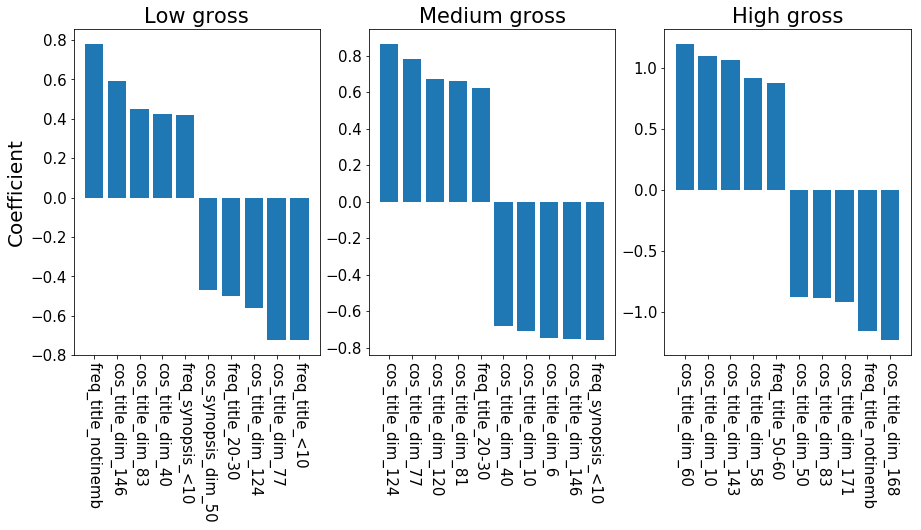

In [126]:
plot_most_relevant_features(model_lr, list(X_train.columns))

Positive association with high grossing:

In [127]:
dimensions[['en_label', 'tokenized']].iloc[[60, 10, 143, 58]]

,en_label,tokenized
60,flowers,"[rose, carnation, tulip, daisy, sunflower, daf..."
10,bad,[bad]
143,theruler,"[ruler, power, prosperous, successful, family,..."
58,female,"[female, woman, girl, sister, she, her, hers, ..."


Positive association with low grossing:

In [128]:
dimensions[['en_label', 'tokenized']].iloc[[146, 83, 40]]

,en_label,tokenized
146,NaN,"[old, traditional, ancestral, hereditary, brou..."
83,lifestyle,"[life, lifestyle, freedom]"
40,innovative,"[innovative, advanced, modern, progressive, av..."


# Conclusion

* Word rank of title/synopsis doesn't seem to be correlated that much with success of a movie.
* Our LR model says that the similarity of the synopsis to the career dimension is associated with high probability of beign a low grosser. On the other side, films with titles semantically linked to evaluating and teaching have high probability of being a high grosser.
* From our sample for Comedy, we see that flowers, bad, female correlate with high gross, while traditional, lifestyle, innovative correlate with low gross.